In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import scipy
from numba import njit

In [2]:
from IPython.display import Audio, display

url_exception = "http://www.wav-sounds.com/movie/austinpowers.wav"
url_exception = "https://www.myinstants.com/media/sounds/roblox-death-sound_1.mp3"


def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio(url=url_exception, autoplay=True))


get_ipython().set_custom_exc((Exception,), play_sound)

url_done = (
    "https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav"
)
url_done = "https://www.myinstants.com/media/sounds/taco-bell-bong-sfx.mp3"
url_done = "https://www.myinstants.com/media/sounds/magic_immune.mp3"


def allDone():
    display(Audio(url=url_done, autoplay=True,))

In [3]:
data_dir = os.path.join(os.getcwd(), "data")
drone_dir = os.path.join(data_dir, "tir_pavel")

In [4]:
video_files = ["pavel0.npy", "pavel1.npy", "pavel2.npy", "pavel3.npy"]

video_np = []
for file in video_files:
    video_np.append(np.load(os.path.join(drone_dir, file)))

print(video_np[0].shape)

(1144, 436, 496)


In [5]:
import datetime as dt


timestamp_files = [
    "timestamp0.npy",
    "timestamp1.npy",
    "timestamp2.npy",
    "timestamp3.npy",
]

timestamp_np = []
for file in timestamp_files:
    timestamp_np.append(np.load(os.path.join(drone_dir, file)).squeeze())


def md(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=matlab_datenum % 1) - dt.timedelta(days=366)
    return pd.Timestamp(day + dayfrac).round("S")


matlab_to_date = np.vectorize(md)
timestamp_np = map(matlab_to_date, timestamp_np)

In [6]:
video_dfs = []
for video, timestamp in zip(video_np, timestamp_np):
    video_dfs.append(pd.DataFrame({"frames": [*video]}))
    video_dfs[-1].index = timestamp

video_dfs[0]

,frames
2019-08-06 12:29:34,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:35,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:36,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:37,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:29:38,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
...,...
2019-08-06 12:48:33,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:48:34,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:48:35,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2019-08-06 12:48:36,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."


#### merging the two:

making the data more coarse: 
* https://stackoverflow.com/a/39952846/6293070
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html 
* we probably want to resample down to half seconds? and take that average?

merging the two:
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html#pandas.merge_asof
* https://stackoverflow.com/a/43979285/6293070
    

In [7]:
label_df_1 = pd.read_hdf(os.path.join(drone_dir, "pavel_label_1"), "/df")
label_df_2 = pd.read_hdf(os.path.join(drone_dir, "pavel_label_2"), "/df")
label_df = pd.concat([label_df_1, label_df_2], axis=0)
print(label_df.shape)

(503881, 29)


In [8]:
label_df = label_df.resample("1S").mean()
print(label_df.shape)

(1924190, 29)


In [9]:
print(pd.Timedelta("5S"))
print(pd.Timedelta("500L"))

0 days 00:00:05
0 days 00:00:00.500000


In [10]:
videos_w_labels = []
for video_df in video_dfs:
    videos_w_labels.append(
        pd.merge_asof(
            video_df,
            label_df,
            left_index=True,
            right_index=True,
            tolerance=pd.Timedelta("3S"),
            direction="nearest",
        )
    )

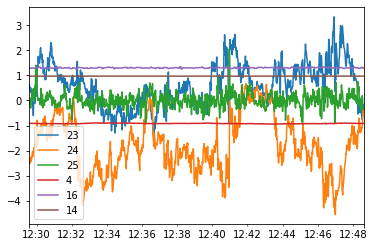

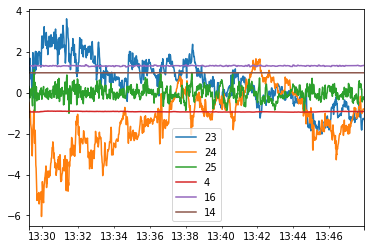

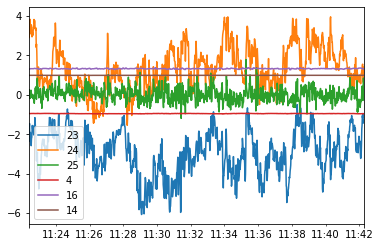

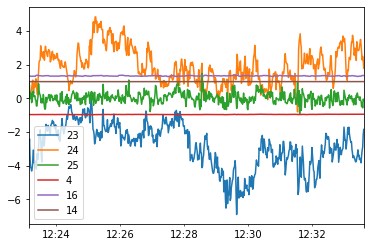

In [11]:
for df in videos_w_labels:
    #     print(df.mean(axis=0, numeric_only=True))
    df[[23, 24, 25, 4, 16, 14]].plot()

# Getting video and labels out of dataframe
* get out one thing for the labels, on thing for the video
* make sure that the video is just a 3d nparray

In [12]:
labels = [23, 24]

label_np = []
for video_w_label in videos_w_labels:
    label_np.append(video_w_label[labels].to_numpy())

Somehow take the center of this:

for now just take width and height from shape
divide it by four

then take the middle half

In [13]:
# might not be the right order!


def get_middle(a):
    video0 = a
    frames, height, width = video0.shape

    cut_off = 4

    left = width // cut_off
    right = width - left
    top = height // cut_off
    bottom = height - top

    video0 = video0[:, top:bottom, left:right]
    return video0

In [14]:
def replace_nan_with_mean(a):
    return np.where(np.isnan(a), np.ones_like(a) * np.nanmean(a), a)

detrending:
* take 30 seconds of video
* wow so detrend...
* for every frame find median value
* everything above median is white (1), everything below is black(0)

(628, 436, 496)
(1144, 436, 496)
(1144, 109, 124)
(1122, 436, 496)
(1122, 109, 124)
(1193, 436, 496)
(1193, 109, 124)
(628, 436, 496)
(628, 109, 124)
(628, 109, 124)
2.084497474900912
-2.084497474900913
0.9398155607297893
0.030138057922649893


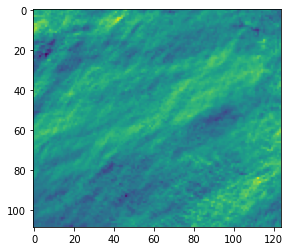

In [15]:
from scipy import signal
from functools import partial
from skimage.transform import rescale

print(video.shape)


def get_frame_middle(frame, cut_off):
    a = frame
    height, width = a.shape

    left = width // cut_off
    right = width - left
    top = height // cut_off
    bottom = height - top

    return a[top:bottom, left:right]


def median_mask(b, n_dev):
    a = b
    std = np.std(a) * n_dev
    median = np.median(a)
    a[a < median - std] = median - std
    a[a >= median + std] = median + std
    return a


# @numba.jit(nopython=False)
def moving_average(video, window_size):
    secs = np.arange(0, video.shape[0])
    mavgl = []
    for i in secs:
        if i >= window_size:
            mavgl.append(np.nanmean(video[i - window_size : i, :, :], axis=0))
        else:
            mavgl.append(np.nanmean(video[: i + 1, :, :], axis=0))
    return np.stack(mavgl, axis=0)


# @numba.jit(nopython=True)
def sigmoid(a):
    return 1 / (1 + np.exp(-a))


def subtract_median(a):
    return a - np.median(a)


def subtract_from_frame(a, sub):
    return a - sub


def divide_by_std(a):
    return a / a.std()


def apply_to_outer_axis(a, func, args=[]):
    b = a
    for i in range(b.shape[0]):
        b[i] = func(b[i], *args)
    return b


def apply_funcs_to_outer_axis(a, funcs):
    """
    args:
    a: thing to apply over
    funcs: list of functions to apply over, can take args
        for example:
            funcs = [f_a, f_b]
            funcs = [(f_a, [1,2,3]), (f_b, [1])]
        a functions with args should be a pair with the args as a list
    """
    for i, f in enumerate(funcs):
        if callable(f):
            funcs[i] = (f, [])

    b = []
    for i in range(a.shape[0]):
        b.append(a[i])
        for f, args in funcs:
            b[i] = f(b[i], *args)
    return np.stack(b, axis=0)


# video = apply_to_outer_axis(video, median_mask)
# video = apply_funcs_to_outer_axis(
#     video, [(get_frame_middle, [4]), subtract_median, sigmoid]
# )

videos_processed = []
for video in video_np:
    print(video.shape)
    video = replace_nan_with_mean(video)
    video = get_middle(video)
    video = (video - np.median(video)) / video.std()
    video = scipy.signal.detrend(video, axis=0)
    video = moving_average(video, 3)
    video = apply_to_outer_axis(video, subtract_median)
    video = apply_to_outer_axis(video, np.tanh)
    video = apply_to_outer_axis(video, median_mask, [2])
    video = apply_to_outer_axis(video, divide_by_std)
    b = []
    for i in range(video.shape[0]):
        b.append(rescale(video[i], 0.5, anti_aliasing=False))
    video = np.stack(b, axis=0)
    videos_processed.append(video)
    print(videos_processed[-1].shape)


# video = replace_nan_with_mean(video)
# video = get_middle(video)
# video = (video - np.median(video)) / video.std()
# video = scipy.signal.detrend(video, axis=0)
# video = moving_average(video, 3)
# video = apply_to_outer_axis(video, subtract_median)
# video = apply_to_outer_axis(video, np.tanh)
# video = apply_to_outer_axis(video, median_mask, [2])
# video = apply_to_outer_axis(video, divide_by_std)
# b = []
# for i in range(video.shape[0]):
#     b.append(rescale(video[i], 0.5, anti_aliasing=False))
# video = np.stack(b, axis=0)


print(video.shape)
print(video[0].max())
print(video[0].min())
print(video[0].std())
print(video[0].mean())

import matplotlib.pyplot as plt

plt.imshow(np.mean(video, axis=0))

# sucessfull video pre-processing stacks
* subtract_median, sigmoid, detrend_all, median_mask
* subtract_median, sigmoid, detrend_all, median_mask(2nd dev)

# how to get more from the data set
* take subsamples, move the labels in time so that they are where the subsample was taken (use an autocorrelation to figure out the timelag between a portion of the greater image and the wind sensor)
* take subsamples near the center (quarters near the center of the image?)

In [16]:
def Tensor_to_video(Tensor, path):
    Tensor = tf.where(
        tf.math.is_nan(Tensor),
        tf.ones_like(Tensor) * np.nanmean(Tensor.numpy()),
        Tensor,
    )
    video = tf.cast(255 * min_max_norm(Tensor), tf.uint8)
    frames, width, height = video.shape
    _fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    out = cv2.VideoWriter(path, _fourcc, 10, (width, height))
    for i in range(frames):
        img = video[i, :, :]
        img = tf.repeat(tf.expand_dims(tf.transpose(img), axis=-1), 3, axis=2).numpy()
        out.write(img)


def min_max_norm(Tensor):
    min = tf.reduce_min(Tensor)
    max = tf.reduce_max(Tensor)
    return (Tensor - min) / (max - min)


# for i, video in enumerate(videos_processed):
#     video_path = os.path.join(data_dir, "videos", "center_video" + str(i) + ".mp4")
#     Tensor_to_video(tf.convert_to_tensor(video), video_path)

# from IPython.display import Video

# video_path = os.path.join(data_dir, "videos", "center_video.mp4")
# Video(video_path)

# allDone()

# things to try:
* how much to downsample?
* does our pre-processing do anything?
<!-- * do we need the whole image -->

In [17]:
# video = np.stack(np.atleast_3d(*video), axis=0)


def add_axis_to_frames(a):
    return np.stack(np.atleast_3d(*a), axis=0)


videos_processed = list(map(add_axis_to_frames, videos_processed))

# ways to shape the data:
* one big list for everything
* 3d video chunks with a few consecutive frames

In [126]:
labels = [23, 24]

label_np = []
for video_w_label in videos_w_labels:
    label_np.append(video_w_label[labels].to_numpy())

In [127]:
# one big list
video = np.concatenate(videos_processed, axis=0)
labels = np.concatenate(label_np, axis=0)

In [128]:
print(video.shape, labels.shape)

(4087, 109, 124, 1) (4087, 2)


In [129]:
from numpy.random import default_rng


def shuffle_arrays(a, b):
    assert a.shape[0] == b.shape[0]
    length = a.shape[0]
    x = a
    y = b
    rng = default_rng()
    idx = rng.choice(length, length)
    x = x[idx]
    y = y[idx]
    return x, y


import random


def chunk_idx_shuffle(a, blocksize):
    idx = np.arange(a.shape[0])
    blocks = [
        idx[i * blocksize : (i + 1) * blocksize] for i in range(len(idx) // blocksize)
    ]
    random.shuffle(blocks)
    return [elt for block in blocks for elt in block]


def shuffle_chunks_arrays(a, b, chunk_size):
    assert a.shape[0] == b.shape[0]
    idx = chunk_idx_shuffle(a, chunk_size)
    x = a
    y = b
    x = x[idx]
    y = y[idx]
    return x, y


# video, labels = shuffle_by_blocks(labels, 10)
# x_train, y_train = shuffle_arrays(x_train, y_train)
video, labels = shuffle_chunks_arrays(video, labels, 10)

In [130]:
def train_val_test(train, val, test, X, y):
    assert train + val + test == 1
    data_len = len(X)
    train_size = int(train * data_len)
    val_size = int(val * data_len)
    test_size = int(test * data_len)

    splits = [
        (0, train_size),
        (train_size, train_size + val_size),
        (train_size + val_size, data_len),
    ]

    x_out = []
    y_out = []
    for a, b in splits:
        x_out.append(X[a:b])
        y_out.append(y[a:b])

    return (*x_out, *y_out)


x_train, x_val, x_test, y_train, y_val, y_test = train_val_test(
    0.8, 0.1, 0.1, video, labels
)

# notes
* does worse if we shuffle the train after a chunk shuffle

In [131]:
x_train, y_train = shuffle_arrays(x_train, y_train)

In [132]:
import tensorflow as tf
import datetime

# Load the TensorBoard notebook extension
%load_ext tensorboard

tf.random.set_seed(1234)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [133]:
model = tf.keras.Sequential(
    [
        #         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(50, 4, activation="relu", input_shape=x_train[0].shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=x_train[0].shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        #         tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        #             tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2),
    ]
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    metrics=["accuracy", "mean_absolute_error"],
)

In [134]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# log_dir = os.path.join(
#     os.getcwd(), "logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# )
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [135]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error", patience=10, restore_best_weights=True
)

In [136]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

model.fit(
    x=x_train,
    y=y_train,
    batch_size=5,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, tensorboard_callback],
)

Num GPUs Available:  1
Epoch 1/100
653/653 [==============================] - 4s 6ms/step - loss: 0.7611 - accuracy: 0.9102 - mean_absolute_error: 0.5896 - val_loss: 0.5300 - val_accuracy: 0.9975 - val_mean_absolute_error: 0.5565
Epoch 2/100
653/653 [==============================] - 4s 6ms/step - loss: 0.1884 - accuracy: 0.9632 - mean_absolute_error: 0.3237 - val_loss: 0.4021 - val_accuracy: 0.9975 - val_mean_absolute_error: 0.4785
Epoch 3/100
653/653 [==============================] - 4s 6ms/step - loss: 0.1398 - accuracy: 0.9712 - mean_absolute_error: 0.2804 - val_loss: 0.4012 - val_accuracy: 0.9926 - val_mean_absolute_error: 0.4779
Epoch 4/100
653/653 [==============================] - 4s 6ms/step - loss: 0.1299 - accuracy: 0.9740 - mean_absolute_error: 0.2682 - val_loss: 0.3787 - val_accuracy: 0.9926 - val_mean_absolute_error: 0.4651
Epoch 5/100
653/653 [==============================] - 4s 6ms/step - loss: 0.1234 - accuracy: 0.9773 - mean_absolute_error: 0.2597 - val_loss: 0.4549

In [137]:
model.evaluate(x=x_test, y=y_test)

13/13 [==============================] - 0s 7ms/step - loss: 0.3442 - accuracy: 0.9681 - mean_absolute_error: 0.4433


[0.3441609740257263, 0.968137264251709, 0.4432756006717682]

In [138]:
preds = model.predict(x=x_test)

In [139]:
print(preds.shape, y_test.shape)

(408, 2) (408, 2)


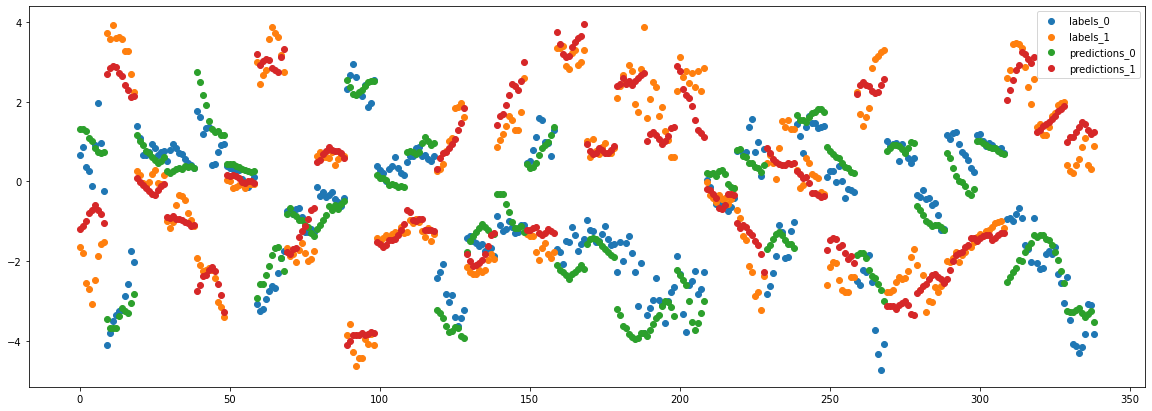

In [140]:
def unstack(a, axis=1):
    return np.moveaxis(a, axis, 0)


def plot(l, r, preds, labels, width=20, height=7):
    assert len(preds[0].shape) == len(labels[0].shape)
    preds = preds[l:r, :]
    labels = labels[l:r, :]
    preds = unstack(preds)
    labels = unstack(labels)
    x = list(range(len(preds[0])))
    plt.rcParams["figure.figsize"] = [width, height]
    for i, label in enumerate(labels):
        plt.scatter(x, label, label="labels_" + str(i))
    for i, pred in enumerate(preds):
        plt.scatter(x, pred, label="predictions_" + str(i))
    plt.legend()
    plt.show()


plot(69, 420, preds, y_test)
allDone()

In [40]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 18132), started 0:04:50 ago. (Use '!kill 18132' to kill it.)